### data set
training: 1-5,2018
testing: 6-7,2018

### feature
- nlp: tf-rdf, word2vec, distance
- image: mutual information 
- log: cosine of aggregated values
- app: cosine of categorical data

### similarity model
- exact match
- same tech issue: logistic regression, metric learning

In [1]:
from __future__ import unicode_literals
import requests
import json
import csv
import matplotlib.pyplot as plt
from sets import Set
import numpy as np
import cPickle
import utils
from difflib import SequenceMatcher
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from scipy.spatial.distance import cosine

%matplotlib inline
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.75, 's' : 120, 'linewidths':0}

%load_ext autoreload
%autoreload 2
import base64
from itertools import izip
import os
import random

import hashlib
from sklearn.metrics.pairwise import cosine_similarity
import glob
from collections import Counter

import sys
import time
from multiprocessing import Pool
#stdout = sys.stdout
#reload(sys)
#sys.setdefaultencoding('utf-8')
#sys.stdout = stdout

/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: the sets module is deprecated


In [2]:
pwd

u'/mnt/cephfs/hadoop-compute/phoenix/ting/wisdom'

In [3]:
!mv ./df_similarity_scores_*.p ./backup/

mv: cannot stat ‘./df_similarity_scores_*.p’: No such file or directory


---

# experimenting, not used 

#### problem with md5 hashing: small changes make large difference

In [ ]:
hashlib.md5('i like to ride uber').hexdigest()

In [ ]:
hashlib.md5('i like to ride uber').hexdigest()

#### feature hasher

In [ ]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=10)
D = [{'dog': 1, 'cat':2, 'elephant':4},{'dog': 2, 'run': 5}]
f = h.transform(D)
f.toarray()

#### tf-idf

In [ ]:
file_list = glob.glob("./response/*.txt")

In [ ]:
filtered_response_list = []
for f in file_list:
    text_file = open(f)
    lines = text_file.read()
    response_list = lines.decode('utf-8', 'ignore').split('\r\n')
    for r in response_list:
        filtered_response_list.append(pre_processing(r,stop_words))

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 1),
    max_features=30000)

vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
vectorizer.fit(filtered_response_list)
tf_idf_matrix = vectorizer.transform(filtered_response_list)

In [ ]:
tf_idf_matrix.shape

In [ ]:
arr = vectorizer.transform(filtered_response_list[0:5]).toarray()

In [ ]:
arr

In [ ]:
cosine_similarity(arr[:2])

---

## data preprocessing

In [49]:
data_dict = {}
filelist = glob.glob("./task_content/*")
for f in filelist:
    with open(f) as json_file:  
        data = json.load(json_file)
        if 'hits' in data:
            if 'hits' in data['hits']:
                for d in data['hits']['hits']:
                    if 'phabId' in d['_source']:
                        data_dict[d['_source']['phabId'][1:]] = d['_source']

In [50]:
len(data_dict)

23144

# nlp basics

In [61]:
import nltk
import nltk
nltk.download('perluniprops')
nltk.download('stopwords')
nltk.download('perluniprops')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import nist
from nltk.tokenize.nist import NISTTokenizer
sno = nltk.stem.SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/udocker/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/udocker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/udocker/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package punkt to /home/udocker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
def jaccard_dist(a,b):
    return float(len(a&b))/float(len(a|b))

In [28]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

In [29]:
def pre_processing(response,stop_words):
    words = response.split()
    filtered_words = ''
    for w in words:
        if w not in stop_words:
            w = sno.stem(w)
            filtered_words = filtered_words + w + ' '
    filtered_response = filtered_words
    return filtered_response

## string similarity: jaccard distance of 3-gram

In [8]:
rlist = ['eta is very super bad', 'eta was bad', 'eta is really bad', 'eta is bad','the eta is super bad']
filter_rlist = [pre_processing(r, stop_words) for r in rlist]

In [9]:
filter_rlist

[u'eta super bad ',
 u'eta bad ',
 u'eta realli bad ',
 u'eta bad ',
 u'eta super bad ']

In [10]:
a = set(ngrams(filter_rlist[0],1)+ ngrams(filter_rlist[0],2)+ ngrams(filter_rlist[0],3))
b = set(ngrams(filter_rlist[1],1)+ ngrams(filter_rlist[1],2)+ ngrams(filter_rlist[1],3))
jaccard_dist(a,b)

0.5

In [11]:
len(a|b)

36

## keyword counts

In [30]:
data = cPickle.load(open('./backup/snaptask1000.p', 'rb'))

In [31]:
descr = ""
for i in range(1000):
    if 'systemDescription' in data['hits']['hits'][i]['_source']:
        descr = descr + data['hits']['hits'][i]['_source']['systemDescription'].encode("utf-8").decode('utf8', 'ignore')

In [32]:
len(descr)

7637560

In [33]:
def descr_preprocess(descr):
    ignore_str = ["=", "\n", "\"","\\","//",":","{","]","}","[",",","`"]
    for s in ignore_str:
        descr = descr.replace(s,' ')
    lowers = descr.lower()
    tokens = nltk.word_tokenize(lowers)
    return tokens

In [36]:
tokens = descr_preprocess(descr)

In [37]:
count = Counter(tokens)

In [38]:
len(count)

11119

In [39]:
strkey = ""
for i in count.most_common(500):
    strkey = strkey + i[0] + "\n"

#### top 500 keywords

In [40]:
keyword = []
for l in count.most_common(500):
    keyword.append(l[0])

In [41]:
def get_descr_feature(keyword, tokens):
    c = {}
    for k in keyword:
        c[k] = 0
    count = Counter(tokens)
    interkey = list(set(keyword).intersection(count.keys()))
    #print interkey
    for ik in interkey:
        c[ik] = count[ik]
    #print c
    feature = []
    for key, value in c.iteritems():
        feature.append(value)
    feature = np.array(feature).reshape(1,-1)
    return feature

In [51]:
dsct = data_dict['1457543']['systemDescription']
dtokens = descr_preprocess(dsct)
a = get_descr_feature(keyword, dtokens)

In [52]:
cosine_similarity(a,a)

array([[ 1.]])

In [53]:
def color_in_tokens(tokens, color_token):
  """
  Highlights the tokens which contain 'color_token_contains'

  :param tokens: list of strings
  :param color_token_contains: str (the string for marking a token red)
  :return: str
  """
  return " ".join(["\x1b[31m%s\x1b[0m" % i if i in color_token else i for i in tokens])
print color_in_tokens(["no color", "in_red","black"],["no color","in_red"])

no color in_red black


In [ ]:
dtokens = descr_preprocess(data_dict['1525053']['systemDescription'])
color_token = keyword
print color_in_tokens(dtokens,color_token)

---

## create feature

In [55]:
def string_matcher(str1, str2): 
    nstr1 = set(ngrams(str1,3)+ngrams(str1,2)+ngrams(str1,1))
    nstr2 = set(ngrams(str2,3)+ngrams(str2,2)+ngrams(str2,1))
      
    if len(nstr1)>0 or len(nstr2)>0:
        return jaccard_dist(nstr1,nstr2)
    elif len(nstr1)==0 and len(nstr1)==0:
        return 1
    else:
        return 0

In [68]:
def os_version_preprocess(os):
    nist = NISTTokenizer()
    os = os.replace('(','')
    os = os.replace(')','')
    os = os.lower()
    os = nist.tokenize(os)
    return os

In [69]:
os_version_preprocess('iOS 11.2.1')

[u'ios', u'11.2.1']

In [70]:
def get_content_snap(data_dict,ids):
    result = {}
    report_id = ids
    content = data_dict[ids]
    
    create_at = ''
    if 'created' in content:
        created_at = content['created']
    
    feature_descr = ''
    if 'featureDescr' in content:
        feature_descr = content['featureDescr']
        
    device_model = ''
    if 'deviceModel' in content:
        device_model = content['deviceModel']
        
    city_id = ''
    if 'city_id' in content:
        city_id = content['city_id']
        
    app_name = '' 
    if 'app' in content:
        app_name = content['app']
        
    user_uuid = ''
    if 'userUuid' in content:
        user_uuid = content['userUuid']
    
    user_input = ''
    if 'userInput' in content:
        user_input = content['userInput']
        if user_input is None:
            user_input = ''
        
    user_summary = ''
    if 'userSummary' in content:
        user_summary = content['userSummary']
        if user_summary is None:
            user_summary = ''
        
        
    os_version = ''
    if 'os' in content:
        os_version = content['os']
    
    app_version = ''
    if 'version' in content:
        app_version = content['version']
    
    descr = ''
    if 'systemDescription' in content:
        descr = content['systemDescription']
        
    locale = ''
    if 'locale' in content:
        locale = content['locale']
    
    rst = {}
    rst['report_id'] = report_id
    rst['created_at'] = created_at
    rst['feature_descr'] = feature_descr
    rst['device_model'] = device_model
    rst['city_id'] = city_id
    rst['app_name'] = app_name
    rst['user_uuid'] = user_uuid
    rst['user_input'] = user_input
    rst['user_summary'] = user_summary
    rst['os_version'] = os_version
    rst['app_version'] = app_version
    rst['descr'] = descr
    rst['locale'] = locale

    return rst

In [71]:
 def get_match_score(t,keyword):
    t1 = t[0]
    t2 = t[1]
    
    input_match = string_matcher(t1['user_input'], t2['user_input'])
    summary_match = string_matcher(t1['user_summary'], t2['user_summary'])
    featureDesc_match = string_matcher(t1['feature_descr'], t2['feature_descr'])
    create_diff = abs(int(t1['created_at'])-int(t2['created_at']))
    
    if t1['device_model'] == t2['device_model']:
        same_device_model = 1
    else:
        same_device_model = 0
    
    if t1['app_name'] == t2['app_name']:
        same_app = 1
    else:
        same_app = 0
        
    if t1['user_uuid'] == t2['user_uuid']:
        same_user = 1
    else:
        same_user = 0
        
    appV1 = t1['app_version']
    appV2 = t2['app_version']
    same_appV1=0
    same_appV2=0
    same_appV3=0
    if len(appV1)==len(appV2):
        appV11 = appV1.split('.')
        appV22 = appV2.split('.')
        if appV11[0] == appV22[0]:
            same_appV1 = 1
        if (appV11[0] == appV22[0]) and (appV11[1] == appV22[1]) :
            same_appV2 = 1    
        if (appV11[0] == appV22[0]) and (appV11[1] == appV22[1]) and (appV11[2] == appV22[2])  :
            same_appV3 = 1
    
    same_os1 = 0
    same_os2 = 0
    os1 = os_version_preprocess(t1['os_version'])
    os2 = os_version_preprocess(t2['os_version'])
    if (len(os1) == len(os2))and (len(os1)==2):
        if os1[0] == os2[0]:
            same_os1 = 1
        if (os1[0] == os2[0]) and (os1[1] == os2[1]):
            same_os2 = 1
    
    same_city = 0
    if t1['city_id'] == t2['city_id']:
        same_city = 1 
    
    same_locale = 0
    if t1['locale'] == t2['locale']:
        same_locale = 1 
        
        
    token1 = descr_preprocess(t1['descr'])
    token2 = descr_preprocess(t2['descr'])
    k1 = get_descr_feature(keyword, token1)
    k2 = get_descr_feature(keyword, token2)
    system_match = cosine_similarity(k1,k2)[0][0]
        
    return t1['report_id'], t2['report_id'], input_match, summary_match, featureDesc_match,create_diff, same_device_model,\
            same_app, same_user, same_appV1, same_appV2, same_appV3, same_os1, same_os2, same_city,same_locale, system_match

In [74]:
t = [get_content_snap(data_dict, '1457543'), get_content_snap(data_dict, '1457545')]

## score duplicated pair

In [80]:
dup_pairs = cPickle.load(open('./backup/1-5_2018_duplicated_pairs.p', 'rb'))

In [81]:
df_dup_pairs = pd.DataFrame.from_records(dup_pairs, columns=['task1','task2'])

In [82]:
df_dup_pairs.count()

task1    4659
task2    4659
dtype: int64

In [84]:
df_snaptask_ids = pd.read_csv('./backup/taskid_list_1-5-2018.txt', sep=" ", header=None)
df_snaptask_ids.columns = ["taskid"]

In [85]:
list_snaptaskids = [i[1:] for i in df_snaptask_ids.taskid.values.tolist()]

In [86]:
df_dup_pairs = df_dup_pairs[(df_dup_pairs.task1.isin(list_snaptaskids) & df_dup_pairs.task2.isin(list_snaptaskids) )]

In [87]:
df_dup_pairs.count()

task1    3834
task2    3834
dtype: int64

In [88]:
df_dup_pairs.head()

,task1,task2
0,1759453,1759451
1,1713183,1713187
2,1544663,1544665
3,1528561,1528569
4,1590589,1590583


In [103]:
df_dup_pairs = df_dup_pairs[(df_dup_pairs.task1.isin(data_dict.keys())) & (df_dup_pairs.task2.isin(data_dict.keys()))]

In [104]:
df_dups = set(df_dup_pairs['task1'].tolist() + df_dup_pairs['task2'].tolist())
len(df_dups)

4074

In [106]:
def compute_feature_for_pair(df,data_dict,keyword):
    d1 = df['task1'].tolist()
    d2 = df['task2'].tolist()
    rst = []
    for p1,p2 in zip(d1,d2):
        t = [get_content_snap(data_dict, p1), get_content_snap(data_dict, p2)]
        #print p1,p2
        v = get_match_score(t,keyword)
        rst.append(v)
        
    df_rst = pd.DataFrame.from_records(rst, columns=['task1','task2','input_match','summary_match','featureDesc_match','create_diff',\
                                           'same_device_model','same_app','same_user','same_appV1','same_appV2','same_appV3',\
                                           'same_os1','same_os2','same_city','same_locale','system_match'])    
        
    return df_rst

In [107]:
df_same = compute_feature_for_pair(df_dup_pairs,data_dict,keyword)

## create random pair

In [108]:
df = df_dup_pairs
d1 = df['task1'].tolist()
d2 = df['task2'].tolist()

In [109]:
random_list = []
for i in range(5000):
    p = random.sample(set(d1+d2), 2)
    if (df[(df['task1']==p[0]) & (df['task2']==p[1])].empty) \
       and (df[(df['task2']==p[0]) & (df['task1']==p[1])].empty):
        random_list.append(p)
df_random = pd.DataFrame.from_records(random_list, columns=['task1','task2'])   

In [110]:
df_random.shape

(4999, 2)

In [111]:
df_random.head(3)

,task1,task2
0,1468847,1699781
1,1694015,1763297
2,1686851,1752437


In [112]:
df_diff = compute_feature_for_pair(df_random,data_dict,keyword)

---

## classification - training  (1-5 2018)

In [114]:
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve,average_precision_score

In [208]:
len(df_diff)

4999

In [209]:
len(df_same)

3350

In [210]:
tasks_same = list(set(df_same.task1.values.tolist() + df_same.task2.values.tolist()))
task_same_test = random.sample(tasks_same, 500)
df_same_train = df_same[(~df_same.task1.isin(task_same_test))&(~df_same.task2.isin(task_same_test))]
df_same_test = df_same[(df_same.task1.isin(task_same_test))|(df_same.task2.isin(task_same_test))]

In [211]:
tasks_diff = list(set(df_diff.task1.values.tolist() + df_diff.task2.values.tolist()))
task_diff_test = random.sample(tasks_diff, 500)
df_diff_train = df_diff[(~df_diff.task1.isin(task_diff_test))&(~df_diff.task2.isin(task_diff_test))]
df_diff_test = df_diff[(df_diff.task1.isin(task_diff_test))|(df_diff.task2.isin(task_diff_test))]

In [212]:
print len(df_same_train), len(df_same_test), len(df_diff_train), len(df_diff_test)

2589 761 3741 1258


In [213]:
data_sim_train = df_same_train[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_os2','same_city','same_locale','system_match']]
data_sim_test = df_same_test[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_os2','same_city','same_locale','system_match']]

In [214]:
data_random_train = df_diff_train[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_os2','same_city','same_locale','system_match']]

data_random_test = df_diff_test[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_os2','same_city','same_locale','system_match']]

In [215]:
data_sim_train.head()

,input_match,summary_match,featureDesc_match,create_diff,same_device_model,same_user,same_appV1,same_appV2,same_appV3,same_os2,same_city,same_locale,system_match
0,1.0,1.000000,1.0,0,1,1,1,1,1,1,1,1,1.0
1,1.0,1.000000,1.0,6,1,1,1,1,1,1,1,1,1.0
2,1.0,1.000000,1.0,66,1,1,1,1,1,1,1,1,1.0
3,0.0,0.160920,1.0,836,1,1,1,1,1,1,1,1,1.0
4,1.0,0.419118,1.0,61,1,1,1,1,1,1,1,1,1.0


In [216]:
corr_matrix = data_sim_train.corr().abs()

In [217]:
corr_matrix

,input_match,summary_match,featureDesc_match,create_diff,same_device_model,same_user,same_appV1,same_appV2,same_appV3,same_os2,same_city,same_locale,system_match
input_match,1.000000,0.532178,0.324878,0.201187,0.250660,0.552087,0.133622,0.348376,0.429584,0.393144,0.364400,0.248558,0.271895
summary_match,0.532178,1.000000,0.444325,0.341555,0.262256,0.744234,0.197440,0.536824,0.618527,0.527095,0.505057,0.302664,0.221149
featureDesc_match,0.324878,0.444325,1.000000,0.370779,0.156081,0.462993,0.239305,0.517906,0.453305,0.421732,0.413338,0.217372,0.110954
create_diff,0.201187,0.341555,0.370779,1.000000,0.094265,0.350837,0.143807,0.444712,0.439448,0.439842,0.326781,0.207542,0.130061
same_device_model,0.250660,0.262256,0.156081,0.094265,1.000000,0.342675,0.531533,0.129495,0.210414,0.322977,0.204665,0.481060,0.670384
same_user,0.552087,0.744234,0.462993,0.350837,0.342675,1.000000,0.239429,0.616628,0.668228,0.655804,0.680189,0.379805,0.249505
same_appV1,0.133622,0.197440,0.239305,0.143807,0.531533,0.239429,1.000000,0.357786,0.305639,0.317879,0.209018,0.475001,0.476383
same_appV2,0.348376,0.536824,0.517906,0.444712,0.129495,0.616628,0.357786,1.000000,0.854250,0.556475,0.523066,0.287057,0.061272
same_appV3,0.429584,0.618527,0.453305,0.439448,0.210414,0.668228,0.305639,0.854250,1.000000,0.603411,0.525602,0.320861,0.170124
same_os2,0.393144,0.527095,0.421732,0.439842,0.322977,0.655804,0.317879,0.556475,0.603411,1.000000,0.467801,0.406722,0.315440


In [218]:
data_sim_train = data_sim_train.fillna(1)
data_random_train = data_random_train.fillna(1)
data_sim_test = data_sim_test.fillna(1)
data_random_test = data_random_test.fillna(1)

In [219]:
X_sim_train = data_sim_train.as_matrix()
X_random_train = data_random_train.as_matrix()
X_sim_test = data_sim_test.as_matrix()
X_random_test = data_random_test.as_matrix()

In [220]:
X_train = np.vstack((X_sim_train, X_random_train))

In [221]:
X_train.shape

(6330, 13)

In [222]:
X_test = np.vstack((X_sim_test, X_random_test))

In [223]:
X_test.shape[0]

2019

In [224]:
labels_train = np.hstack((np.ones(X_sim_train.shape[0]), np.zeros(X_random_train.shape[0])))
y_train = labels_train.astype(int)

labels_test = np.hstack((np.ones(X_sim_test.shape[0]), np.zeros(X_random_test.shape[0])))
y_test = labels_test.astype(int)
print y_train.shape, y_test.shape

(6330,) (2019,)


In [225]:
#X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [226]:
X_train_transformed[0]

array([ 1.74583208,  3.80148245,  1.8662782 , -1.09889063,  0.90959728,
        3.20052172,  0.75005143,  2.32527043,  2.73176991,  1.91974431,
        1.92791093,  1.04558786,  1.1227981 ])

In [227]:
lrcf = LogisticRegression()
lrcf.fit(X_train_transformed, y_train)
lrcf.score(X_test_transformed, y_test)
lrcf.predict_proba(X_test_transformed)

array([[  4.79604913e-06,   9.99995204e-01],
       [  1.78733044e-01,   8.21266956e-01],
       [  5.36818529e-01,   4.63181471e-01],
       ..., 
       [  7.96936383e-01,   2.03063617e-01],
       [  7.10185739e-01,   2.89814261e-01],
       [  7.90469193e-01,   2.09530807e-01]])

In [161]:
lrcf.intercept_

array([ 0.17790397])

In [162]:
lrcf.coef_.ravel()

array([-0.02270788,  1.9131518 ,  0.83500918, -0.37331369, -0.09458099,
        0.29763006,  0.07672596, -0.02262884,  0.23811795, -0.13005554,
        0.20507261,  0.19634638,  0.30770829])

In [163]:
y_score = lrcf.decision_function(X_test_transformed)
y_score

array([-0.69824892,  0.55704343,  0.63284198, ..., -0.80523661,
       -1.92338419, -1.2880162 ])

In [164]:
# decision_function
prob = np.transpose(np.matmul(np.array(X_test_transformed),np.transpose(lrcf.coef_)))[0] + np.ones(1918)*lrcf.intercept_
prob

array([-0.69824892,  0.55704343,  0.63284198, ..., -0.80523661,
       -1.92338419, -1.2880162 ])

In [165]:
# softmax
np.exp(prob) / np.sum(np.exp(prob), axis=0)

array([  4.12851436e-08,   1.44863954e-07,   1.56271301e-07, ...,
         3.70962178e-08,   1.21261884e-08,   2.28908079e-08])

In [166]:
# prob
1/(1+np.exp(-prob))

array([ 0.33220058,  0.63576817,  0.65313359, ...,  0.30890647,
        0.12748466,  0.21618878])

In [167]:
#clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
#lr_scores = cross_val_score(clf, X,labels, cv=cv)
#lr_scores

Average precision-recall score: 0.83


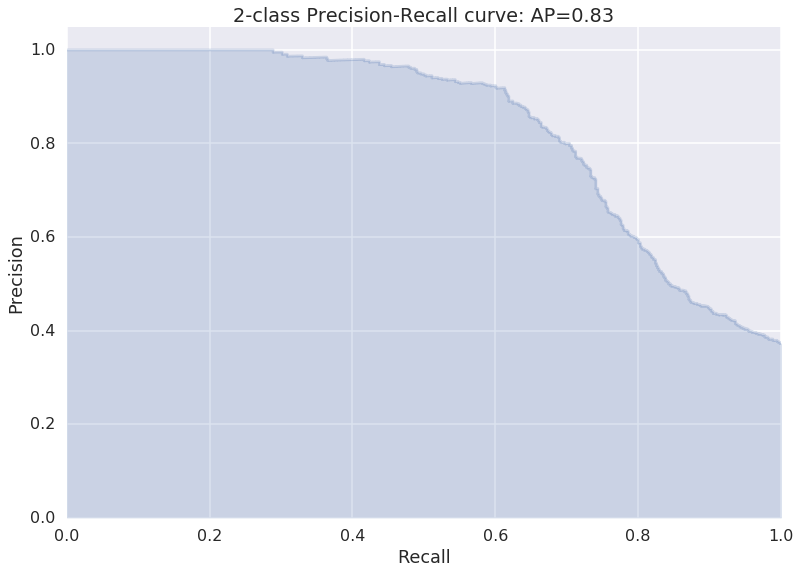

In [168]:
y_score = lrcf.decision_function(X_test_transformed)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

([<matplotlib.axis.XTick at 0x7f7eb0337c50>,
 <a list of 13 Text xticklabel objects>)

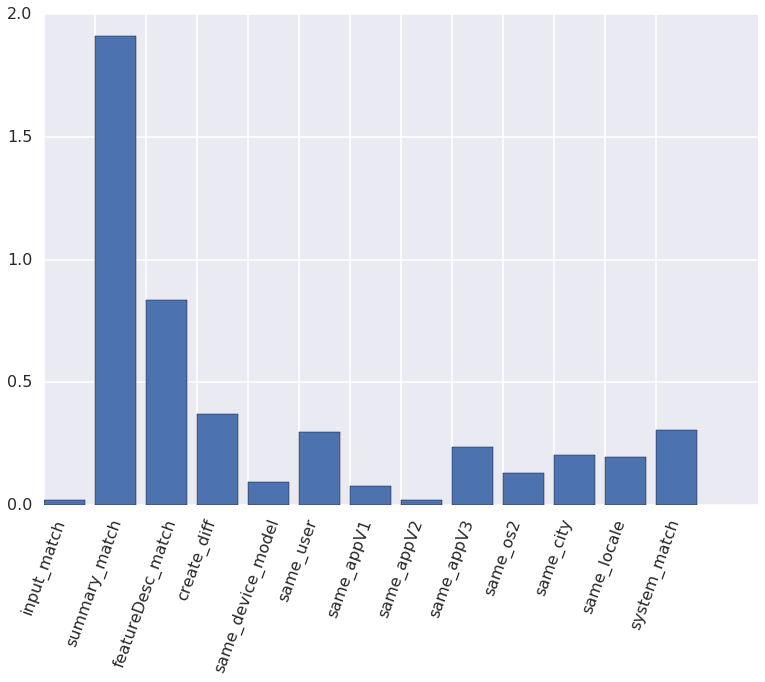

In [169]:
feature_names = ['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_os2','same_city','same_locale','system_match']
coef = abs(lrcf.coef_.ravel())
plt.figure()
plt.bar(np.arange(len(feature_names)), coef)
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=70)

## classification - evaluation  (6-7 2018)

In [179]:
dup_pairs_eval = cPickle.load(open('./backup/6-7_2018_duplicated_pairs.p', 'rb'))

In [180]:
df_dup_pairs_eval = pd.DataFrame.from_records(dup_pairs_eval, columns=['task1','task2'])

In [193]:
df_dup_pairs_eval.count()

task1    297
task2    297
dtype: int64

In [182]:
#df_snaptask_ids = pd.read_csv('./backup/taskid_list_6-7-2018.txt', sep=" ", header=None)
#df_snaptask_ids.columns = ["taskid"]

In [174]:
#list_snaptaskids = [i[1:] for i in df_snaptask_ids.taskid.values.tolist()]

In [175]:
#df_dup_pairs_eval = df_dup_pairs_eval[(df_dup_pairs_eval.task1.isin(list_snaptaskids) & df_dup_pairs_eval.task2.isin(list_snaptaskids) )]

In [184]:
df_dup_pairs_eval.head()

,task1,task2
0,1841427,1841425
1,1820471,1820475
2,1820473,1820475
3,1833717,1721077
4,1833729,1833721


In [185]:
df_dup_pairs_eval = df_dup_pairs_eval[(df_dup_pairs_eval.task1.isin(data_dict.keys())) & (df_dup_pairs_eval.task2.isin(data_dict.keys()))]

In [186]:
df_dups_eval = set(df_dup_pairs_eval['task1'].tolist() + df_dup_pairs_eval['task2'].tolist())
len(df_dups_eval)

431

In [187]:
df_same_eval = compute_feature_for_pair(df_dup_pairs_eval,data_dict,keyword)

In [188]:
tasks_same = list(set(df_same_eval.task1.values.tolist() + df_same_eval.task2.values.tolist()))

In [189]:
data_sim_eval = df_same_eval[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_os2','same_city','same_locale','system_match']]

In [190]:
data_sim_eval = data_sim_eval.fillna(1)

In [191]:
X_sim_eval = data_sim_eval.as_matrix()

In [192]:
X_sim_eval.shape

(297, 13)

In [196]:
labels_eval = np.ones(X_sim_eval.shape[0])

In [195]:
X_sim_eval_transformed = scaler.transform(X_sim_eval)

In [204]:
X_sim_eval_transformed

array([[ 1.74206222,  3.82887525,  1.89070502, ...,  1.91668773,
         1.03723449,  1.13895032],
       [ 1.74206222,  3.82887525,  1.89070502, ...,  1.91668773,
         1.03723449,  1.13895032],
       [ 1.74206222,  3.82887525,  1.89070502, ...,  1.91668773,
         1.03723449,  1.13895032],
       ..., 
       [ 1.74206222, -0.53131739, -0.10944071, ..., -0.5217334 ,
         1.03723449,  1.0613924 ],
       [-0.73346058,  0.71970835, -0.53838112, ..., -0.5217334 ,
         1.03723449,  0.85430853],
       [ 1.74206222, -0.2991775 ,  1.89070502, ..., -0.5217334 ,
         1.03723449,  0.79320515]])

In [228]:
lrcf.score(X_sim_eval_transformed,labels_eval)

0.68013468013468015